<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [2]:
# !pip install gdown -q

In [3]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

In [4]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('./content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [5]:
from pathlib import Path

In [6]:
data_dir = Path('./content')

In [7]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklift.metrics import make_uplift_scorer, qini_auc_score as qini_score
from sklift.viz import plot_qini_curve
from sklift.models import SoloModel, TwoModels, ClassTransformation
from causalml.inference.tree import UpliftRandomForestClassifier

/home/jovyan/stanishevskiy/envs/uplift_mag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [8]:
features = pd.read_csv(data_dir.joinpath('ДЗ по Uplift обновленное/AGGS_FINAL.csv'), parse_dates=['report_dt'], index_col=0)
campaigns = pd.read_csv(data_dir.joinpath('ДЗ по Uplift обновленное/CAMPAINGS.csv'), index_col=0)
contacts_final = pd.read_csv(data_dir.joinpath('ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv'), parse_dates=['contract_date'], index_col=0)
people_in_campaings_final = pd.read_csv(data_dir.joinpath('ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv'), parse_dates=['delivery_date'], na_values=['unknown'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'), index_col=0)

/tmp/ipykernel_43070/495971640.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  people_in_campaings_final = pd.read_csv(data_dir.joinpath('ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv'), parse_dates=['delivery_date'], na_values=['unknown'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'), index_col=0)


In [9]:
contracts_final_filtered = contacts_final[contacts_final['product_id'] == 1]

In [10]:
merged_data = people_in_campaings_final.merge(contracts_final_filtered, on='user_id', how='left')

In [11]:
merged_data['contract_date'] = pd.to_datetime(merged_data['contract_date'])
merged_data['delivery_date'] = pd.to_datetime(merged_data['delivery_date'], errors='coerce')

In [12]:
merged_data['target'] = 0
target_condition_treated = (
    (merged_data['t_flag'] == 1) &
    (merged_data['contract_date'] <= merged_data['delivery_date'] + timedelta(weeks=2))
)

In [13]:
campaign_start_date = datetime(2024, 11, 1)
target_condition_control = (
    (merged_data['t_flag'] == 0) &
    (merged_data['contract_date'] <= campaign_start_date + timedelta(weeks=3))
)

In [14]:
merged_data.loc[target_condition_treated | target_condition_control, 'target'] = 1

In [15]:
uplift_results = merged_data.groupby('campaing_id').apply(
    lambda x: x[x['t_flag'] == 1]['target'].mean() - x[x['t_flag'] == 0]['target'].mean()
).reset_index(name='uplift')

print("\nUplift для каждой кампании:")
print(uplift_results)


Uplift для каждой кампании:
  campaing_id    uplift
0      idclip -0.286300
1       iddqd  0.484875
2        iddt  0.287017
3       idkfa  0.301533


/tmp/ipykernel_43070/1820005953.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_results = merged_data.groupby('campaing_id').apply(


In [16]:
merged_data = merged_data[merged_data.campaing_id != 'idclip']

In [17]:
output_table = merged_data[['user_id', 'target', 'campaing_id']].copy()
output_table['report_dt'] = '2024-11-30'
output_table = output_table.drop_duplicates(subset=['user_id', 'report_dt'])
output_table.reset_index(drop=True, inplace=True)


In [18]:
print("Количество пропущенных значений:\n", output_table.isnull().sum())
print("\nКоличество дубликатов:", output_table.duplicated().sum())

Количество пропущенных значений:
 user_id        0
target         0
campaing_id    0
report_dt      0
dtype: int64

Количество дубликатов: 0


In [19]:
print("\nРаспределение целевой переменной:")
print(output_table['target'].value_counts(normalize=True))



Распределение целевой переменной:
target
1    0.506557
0    0.493443
Name: proportion, dtype: float64


In [20]:
anomalies = merged_data.groupby('user_id')['t_flag'].nunique().reset_index()
anomalies = anomalies[anomalies['t_flag'] > 1]
print("\nКоличество пользователей в обеих группах:", len(anomalies))


Количество пользователей в обеих группах: 0


Аномалий не обнаружено  
полных дубликатов нет  
с sms отрицательный импрув по таргету, удалена группа  
в merged_data некоторые пользователи идентичны по некоторым параметрам. Поэтому дальше будут выбраны данны для таких пользователей на основании наиболее раней даты.  
Распределение таргета сбалансированно  


<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [21]:
features['report_dt'] = pd.to_datetime(features['report_dt'])

In [22]:
features_lagged = features.copy()
features_lagged['report_dt'] = features_lagged['report_dt'] + pd.DateOffset(months=2)

In [23]:
output_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      400000 non-null  int64 
 1   target       400000 non-null  int64 
 2   campaing_id  400000 non-null  object
 3   report_dt    400000 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.2+ MB


In [24]:
output_table.report_dt = pd.to_datetime(output_table['report_dt'])

In [25]:
merged_with_features = output_table.merge(features_lagged, on=['user_id', 'report_dt'], how='left')

In [26]:
print("\nКоличество пропущенных значений после объединения:\n", merged_with_features.isnull().sum())


Количество пропущенных значений после объединения:
 user_id        0
target         0
campaing_id    0
report_dt      0
x1             0
x2             0
x3             0
x4             0
x5             0
x6             0
x7             0
x8             0
x9             0
age            0
city           0
dtype: int64


### ваши выводы здесь

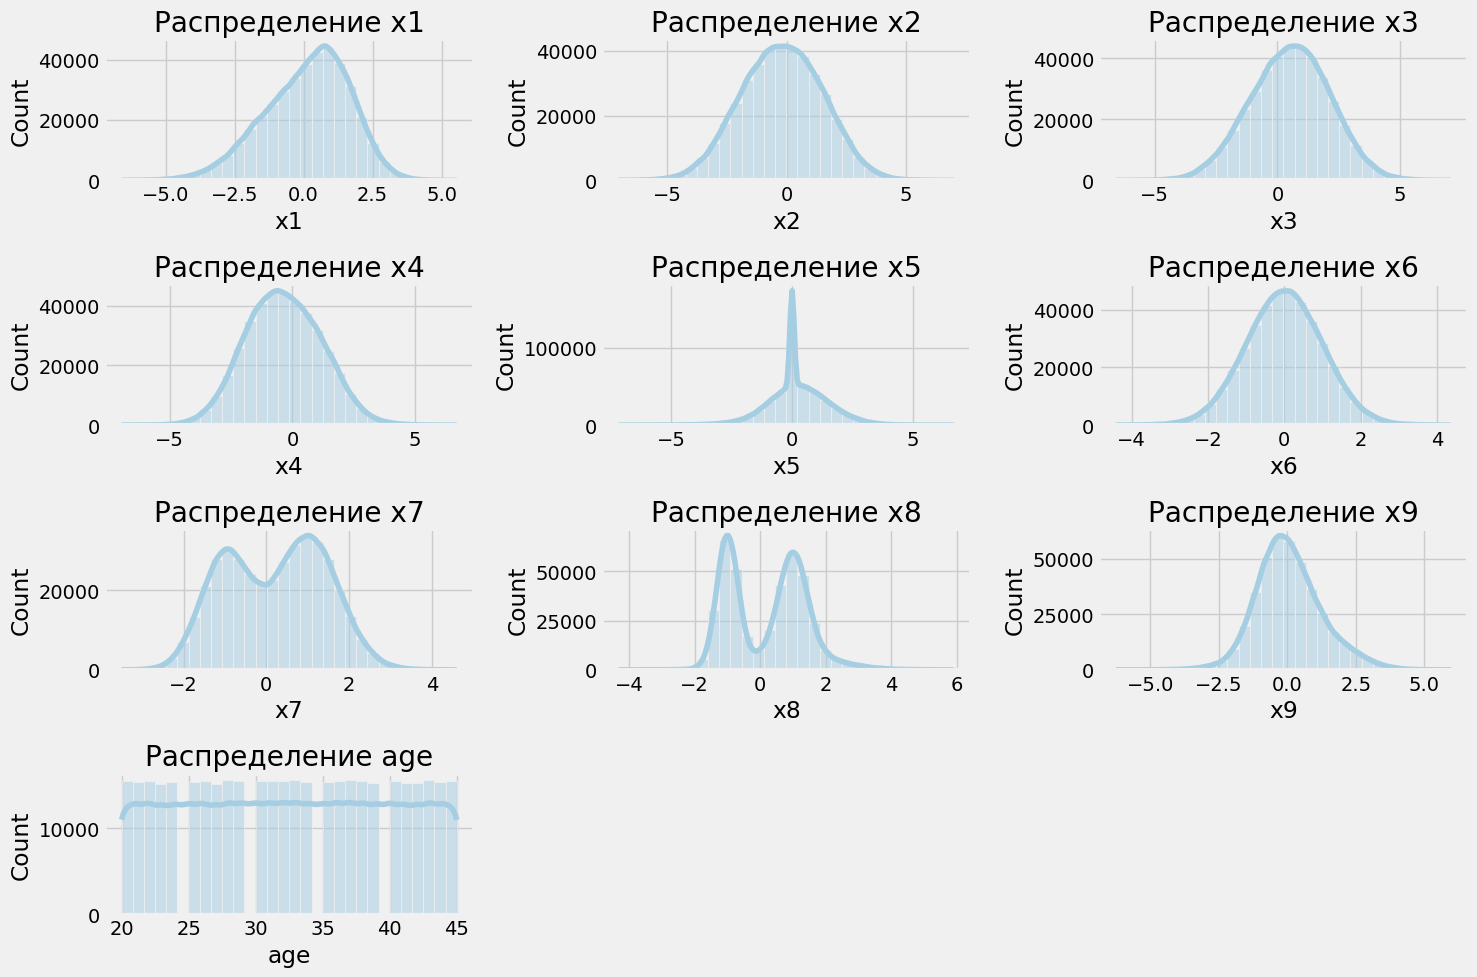

In [27]:
numerical_features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.histplot(merged_with_features[feature], bins=30, kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()



Uplift по каналам:
Канал iddqd: Uplift = 0.4849
Канал iddt: Uplift = 0.2870
Канал idkfa: Uplift = 0.3015


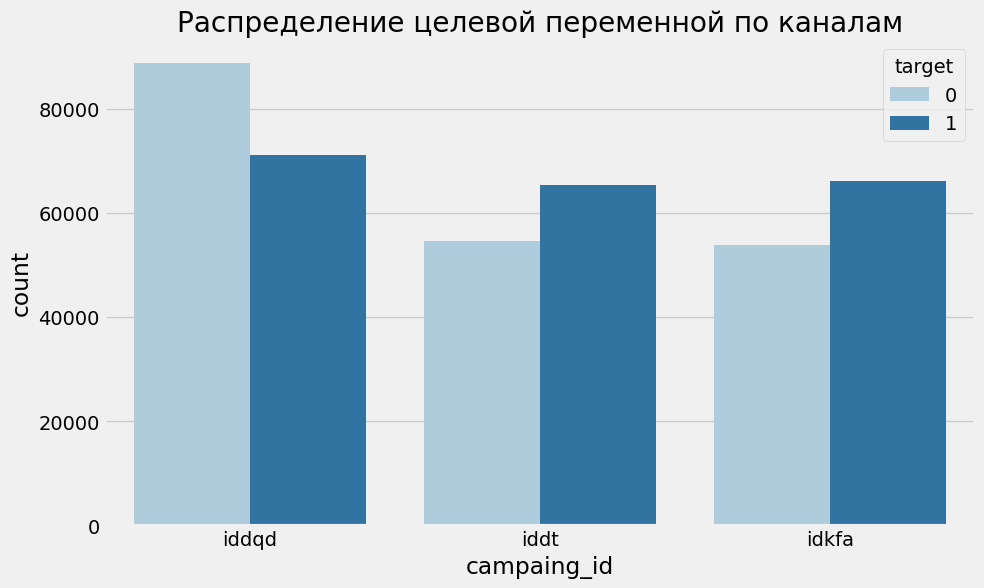

In [28]:
channels = merged_data['campaing_id'].unique()
uplift_by_channel = {}

for channel in channels:
    channel_data = merged_data[merged_data['campaing_id'] == channel]
    uplift_by_channel[channel] = (
        channel_data[channel_data['t_flag'] == 1]['target'].mean() -
        channel_data[channel_data['t_flag'] == 0]['target'].mean()
    )

print("\nUplift по каналам:")
for channel, uplift in uplift_by_channel.items():
    print(f"Канал {channel}: Uplift = {uplift:.4f}")

plt.figure(figsize=(10, 6))
sns.countplot(x='campaing_id', hue='target', data=merged_data)
plt.title('Распределение целевой переменной по каналам')
plt.show()

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [29]:
X = merged_with_features.drop(columns=['user_id', 'report_dt', 'target', 'city', 'campaing_id'])
y = merged_with_features['target']
treatment = merged_data.sort_values(['user_id', 'delivery_date']).drop_duplicates(subset='user_id').set_index('user_id').loc[merged_with_features.user_id.tolist(), 't_flag'].reset_index(drop=True)

In [30]:
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42, stratify=y
)
print(f"Размер тренировочного набора: {X_train.shape}")
print(f"Размер тестового набора: {X_test.shape}")


Размер тренировочного набора: (280000, 10)
Размер тестового набора: (120000, 10)


Qini Score solo_model: 0.3153384219289739


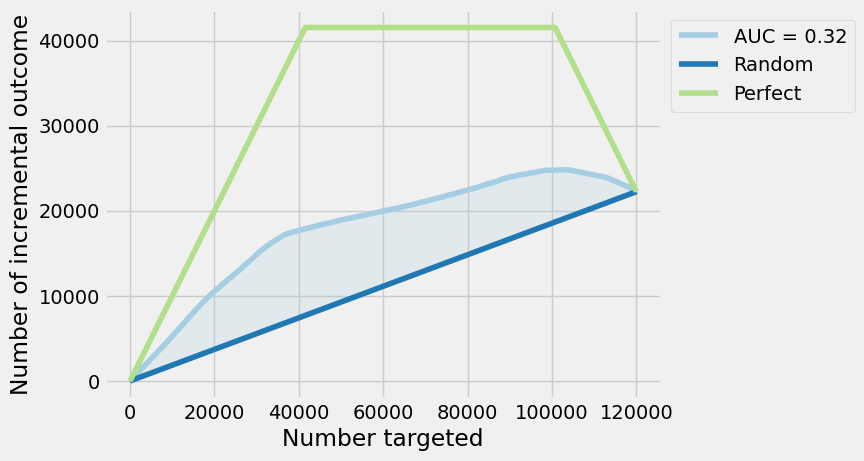

In [31]:
#**SoloModel**
solo_model = SoloModel(
    RandomForestClassifier(n_estimators=100, random_state=42)
)
solo_model.fit(X_train, y_train, treatment_train)
uplift_solo = solo_model.predict(X_test)

qini = qini_score(
    y_true=y_test, 
    uplift=pd.Series(uplift_solo, index=X_test.index),
    treatment=treatment_test 
)
print(f"Qini Score solo_model: {qini}")

plot_qini_curve(
    y_true=y_test, 
    uplift=pd.Series(uplift_solo, index=X_test.index),
    treatment=treatment_test
    );

Qini Score two_model: 0.3112985149086025


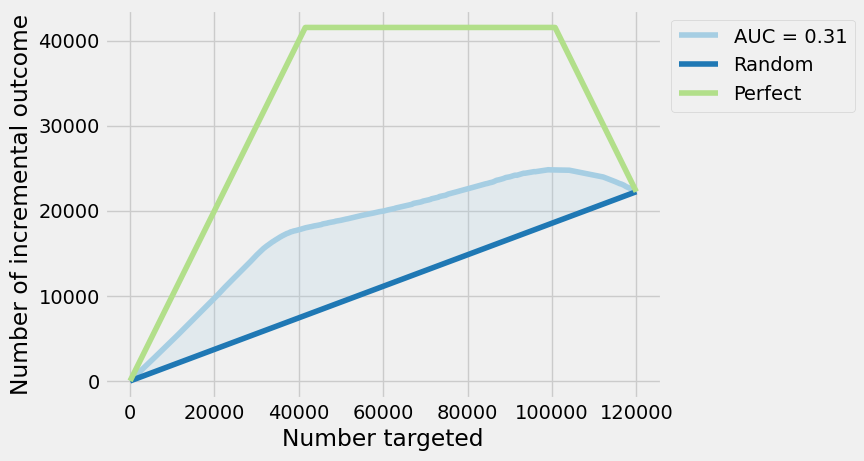

In [32]:
#**TwoModel**
tm_control = RandomForestClassifier(n_estimators=100, random_state=42)
tm_treatment = RandomForestClassifier(n_estimators=100, random_state=42)

two_model = TwoModels(
    estimator_trmnt=tm_treatment,
    estimator_ctrl=tm_control,
    method='vanilla'
)
two_model.fit(X_train, y_train, treatment_train)
uplift_two = two_model.predict(X_test)

qini = qini_score(
    y_true=y_test, 
    uplift=pd.Series(uplift_two, index=X_test.index),
    treatment=treatment_test
)
print(f"Qini Score two_model: {qini}")
plot_qini_curve(
    y_true=y_test, 
    uplift=pd.Series(uplift_two, index=X_test.index),
    treatment=treatment_test
    );

Qini Score ct_model: 0.41765097334819723


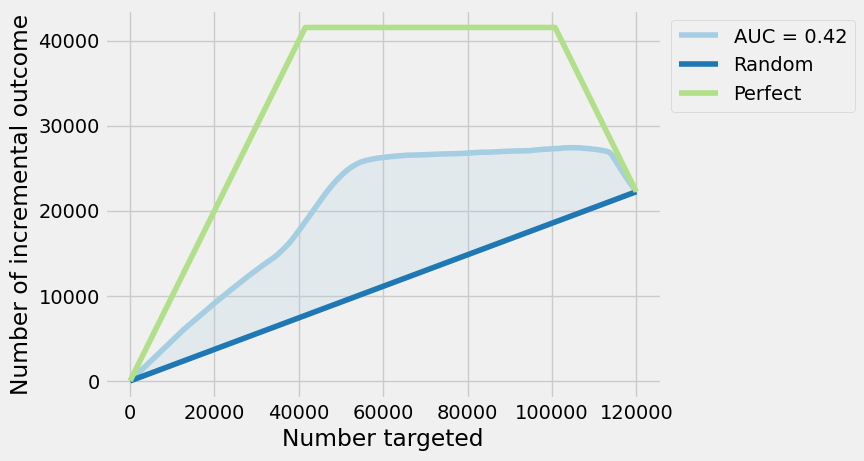

In [33]:
# ClassTransformation
ct_model = ClassTransformation(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)
ct_model.fit(X_train, y_train, treatment_train)
uplift_ct = ct_model.predict(X_test)

qini = qini_score(
    y_true=y_test, 
    uplift=pd.Series(uplift_ct, index=X_test.index),
    treatment=treatment_test
)
print(f"Qini Score ct_model: {qini}")
plot_qini_curve(
    y_true=y_test, 
    uplift=pd.Series(uplift_ct, index=X_test.index),
    treatment=treatment_test
);

Qini Score uplift_rf_preds: 0.21015568575019042


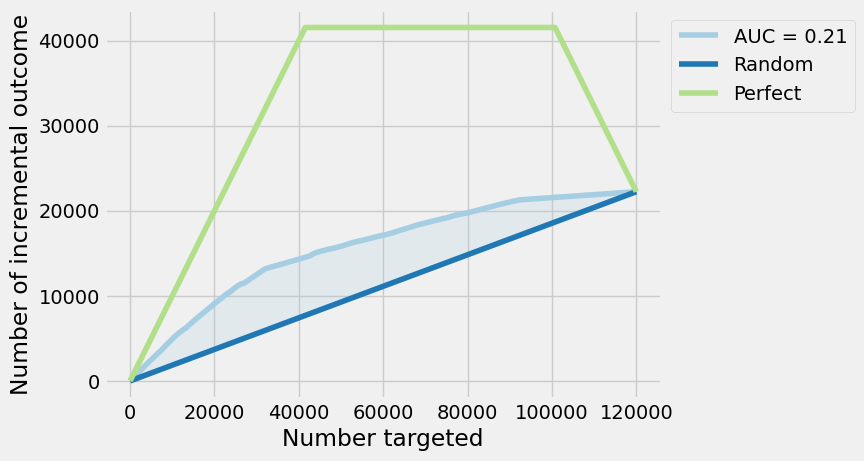

In [34]:
# UpliftRandomForest
uplift_rf = UpliftRandomForestClassifier(
    n_estimators=100,
    control_name='0',
    random_state=42
)
uplift_rf.fit(
    X=X_train.values, 
    y=y_train.values, 
    treatment=treatment_train.astype('str').values
    )
uplift_rf_preds = uplift_rf.predict(X_test.values)

qini = qini_score(
    y_true=y_test, 
    uplift=pd.Series(uplift_rf_preds.reshape(-1), index=X_test.index),
    treatment=treatment_test
)
print(f"Qini Score uplift_rf_preds: {qini}")
plot_qini_curve(
    y_true=y_test, 
    uplift=pd.Series(uplift_rf_preds.reshape(-1), index=X_test.index),
    treatment=treatment_test
);

In [35]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [36]:
def objective_tm_rf(trial):
    param = {
        'n_estimators_1': trial.suggest_int(name="n_estimators_1", low=50, high=200, step=5),
        'max_depth_1': trial.suggest_int(name="max_depth_1", low=7, high=15, step=1),
        'n_estimators_2': trial.suggest_int(name="n_estimators_2", low=75, high=150, step=5),
        'max_depth_2': trial.suggest_int(name="max_depth_2", low=7, high=15, step=1),
        'method': trial.suggest_categorical(name="method", choices=['vanilla', 'ddr_control'])
    }

    model_1 = RandomForestClassifier(
        random_state=42,
        n_estimators=param['n_estimators_1'],
        max_depth=param['max_depth_1']
    )
    model_2 = RandomForestClassifier(
        random_state=42,
        n_estimators=param['n_estimators_2'],
        max_depth=param['max_depth_2']
    )

    tm = TwoModels(estimator_trmnt=model_1,
                   estimator_ctrl=model_2,
                   method=param['method'])

    pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('model_uplift', tm)])

    qini_scorer = make_uplift_scorer("qini_auc_score", treatment_train)

    cross_val = cross_validate(pipe,
                               X=X_train,
                               y=y_train,
                               fit_params={'model_uplift__treatment': treatment_train},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    return cross_val['test_score'].mean()

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_tm = optuna.create_study(direction="maximize")
study_tm.optimize(objective_tm_rf, n_trials=75, show_progress_bar=True)

print("Best trial:")
trial = study_tm.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial: 43. Best value: 0.299143:  92%|█████████▏| 69/75 [1:14:49<07:33, 75.60s/it]

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [36]:
results = pd.DataFrame({
    'user_id': merged_with_features.loc[X_test.index, 'user_id'].tolist(),
    'report__dt': ['2025-01-31']*len(X_test),#  **Примерная дата для прогноза на март**
    'channel': merged_with_features.loc[X_test.index, 'campaing_id'].tolist(),
    'uplift': list(uplift_ct)
})

In [37]:
channel_map = campaigns[['campaing_id', 'channel']].set_index('campaing_id').to_dict(orient='dict')['channel']

In [38]:
results_df = pd.DataFrame(results)
results_df.channel = results_df.channel.map(channel_map)

In [39]:
def select_best(df):
    return df.sort_values('channel', ascending=False).head(1)

In [40]:
results_df = results_df.groupby('user_id').apply(select_best).reset_index(drop=True)

/tmp/ipykernel_43070/3226936377.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_df = results_df.groupby('user_id').apply(select_best).reset_index(drop=True)


In [41]:
results_df

,user_id,report__dt,channel,uplift
0,1,2025-01-31,push,0.34
1,7,2025-01-31,push,0.14
2,12,2025-01-31,push,0.80
3,18,2025-01-31,push,0.02
4,23,2025-01-31,push,1.00
...,...,...,...,...
119995,4119988,2025-01-31,banner,0.18
119996,4119990,2025-01-31,banner,0.26
119997,4119993,2025-01-31,banner,-0.54
119998,4119995,2025-01-31,banner,0.92


In [42]:
results_df.groupby('channel').uplift.mean()

channel
banner       0.322821
other_ads    0.267025
push         0.472683
Name: uplift, dtype: float64

реализованы и протестировали несколько моделей для uplift-моделирования, включая SoloModel, TwoModels, ClassTransformation и UpliftRandomFores.
Оптимизация гиперпараметров была выполнена с использованием Optuna, улучшения для модели TwoModels не наблюдается.  

    Qini Score sol_model: 0.3153384219289739  
    Qini Score two__model: 0.3112985149086025  
    Qini Score ct_model: 0.41765097334819723  
    Qini Score uplift_rf_preds: 0.21015568575019042  
СlassTransformation (ct_model): Показал наивысший Qini Score (0.4177), что указывает на его высокую эффективность в задаче uplift-моделирования в данном контексте.

Дальнейшие улучшения
- попробовать подобрать параметры для СlassTransformation.  
- Выбрать в качестве базовой модели LogReg, Boosting и т.п. 
- Расширить сетку перебора параметров и увеличить кол-во итераций.

Предпочтительный канал:

Для определения предпочтительного канала связи push